--- 

## <center> Project ML for Time Series 
### <center> Feature Selection: A Data Perspective (Part 2)
### <center> Classification Problem
<center>Work done by : 

##### <center> Ali HAIDAR: ali.haidar@polytechnique.edu
##### <center> Maya AWADA: maya.awada@ip-paris.fr 

---

#### Importing Libraries

In [26]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score,confusion_matrix, mean_absolute_error , r2_score , mean_squared_error, mean_absolute_percentage_error
from tabulate import tabulate
import features_selection
import evaluation
warnings.filterwarnings("ignore")

#### Loading and Sampling Data

The MHealth dataset is a multi-variate time series dataset that deals with human behavior analysis based on multimodal body sensing. The dataset was found in the UCI machine learning repository. It contains body motion and vital signs recordings for 10 volunteers of various profile while performing 12 different physical activities. The gooal of this classification problem is to predict which activity the subject is doing provided the following features:

- ACX:	Acceleration From The Chest Sensor (X Axis)
- ACY:	Acceleration From The Chest Sensor (Y Axis)
- ACZ:	Acceleration From The Chest Sensor (Z Axis)
- ES1:	Electrocardiogram Signal (Lead 1)
- ES2:	Electrocardiogram Signal (Lead 2)
- ALX:	Acceleration From The Left-Ankle Sensor (X Axis)
- ALY:	Acceleration From The Left-Ankle Sensor (Y Axis)
- ALZ:	Acceleration From The Left-Ankle Sensor (Z Axis)
- GLX:	Gyroscope From The Left-Ankle Sensor (X Axis)
- GLY:	Gyroscope From The Left-Ankle Sensor (Y Axis)
- GLZ:	Gyroscope From The Left-Ankle Sensor (Z Axis)
- MLX:	Magnetometer From The Left-Ankle Sensor (X Axis)
- MLY:	Magnetometer From The Left-Ankle Sensor (Y Axis)
- MLZ:	Magnetometer From The Left-Ankle Sensor (Z Axis)
- ARX:	Acceleration From The Right-Lower-Arm Sensor (X Axis)
- ARY:	Acceleration From The Right-Lower-Arm Sensor (Y Axis)
- ARZ:	Acceleration From The Right-Lower-Arm Sensor (Z Axis)
- GRX:	Gyroscope From The Right-Lower-Arm Sensor (X Axis)
- GRY:	Gyroscope From The Right-Lower-Arm Sensor (Y Axis)
- GRZ:	Gyroscope From The Right-Lower-Arm Sensor (Z Axis)
- MRX:	Magnetometer From The Right-Lower-Arm Sensor (X Axis)
- MRY:	Magnetometer From The Right-Lower-Arm Sensor (Y Axis)
- MRZ:	Magnetometer From The Right-Lower-Arm Sensor (Z Axis)

In [27]:
df = pd.DataFrame()

for i in range(1,11):
    data = pd.read_csv("classification_data/mHealth_subject"+str(i)+".log", sep="\t", header=None, encoding="utf-8")
    # Sampling Stretgy: For each participant, we randomly select 50 examples of each physical activity
    data = data.groupby(data.iloc[:, -1], group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))
    data = data.assign(subject = [i for j in range(data.shape[0])])
    df = df.append(data)

df.columns = ['acx', 'acy', 'acz', 'es1', 'es2', 'alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'mlx', 'mly', 'mlz', 'arx', 'ary', 'arz', 'grx',
       'gry', 'grz', 'mrx', 'mry', 'mrz', 'Activity', 'Subject']


In [28]:
df

,acx,acy,acz,es1,es2,alx,aly,alz,glx,gly,...,ary,arz,grx,gry,grz,mrx,mry,mrz,Activity,Subject
129854,-5.13280,-0.42962,-0.554460,-0.19257,-0.376770,-0.92798,-10.637000,0.64637,-0.13173,-0.78612,...,-8.00360,0.64149,-0.443140,-0.70842,0.80819,-8.13380,-5.48350,-12.02100,0,1
104797,-7.55910,2.19670,2.060900,0.61120,1.632700,1.38590,-9.541000,-3.60900,-0.48980,-0.88743,...,-13.68000,2.99310,-0.033333,-1.01850,-0.47198,-13.73400,-26.90500,-181.59000,0,1
65494,-9.39930,0.26834,2.150500,-0.16745,-0.159080,3.12760,-9.153000,0.54238,0.23191,-0.65291,...,-9.03900,1.10010,-0.749020,-0.56468,0.62931,5.67280,10.72800,-10.46300,0,1
43273,-9.66470,0.40887,1.973600,-0.16327,-0.355830,1.97910,-9.578400,0.57212,-0.40074,-0.77861,...,-8.93880,2.11560,-0.925490,-0.49487,0.43534,0.34989,-0.91800,-0.70584,0,1
93560,-8.38060,0.84945,2.634300,0.36421,0.531660,0.70987,-19.301000,-3.41630,-0.61410,-0.78799,...,-8.44520,-0.51601,-0.333330,-0.97125,-0.36853,-6.86580,-76.16400,126.26000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95618,0.95214,0.37272,0.044071,2.18110,1.486100,1.64750,-1.007000,-5.64850,0.63636,-0.59662,...,-0.51661,1.33880,-0.503920,-0.94867,0.36638,-12.20700,0.11174,-55.48000,12,10
95246,-21.91100,4.64290,-12.466000,-0.27211,-0.460490,1.09330,-15.288000,-6.98260,0.72913,-0.46154,...,-13.72200,6.84520,-0.268630,-1.00410,0.42888,-2.04730,-7.24400,-36.79200,12,10
95659,-8.10190,1.05260,-4.273700,-0.18420,-0.079540,-4.64860,-19.302000,-1.51160,0.73840,-0.20638,...,-10.74000,9.00470,-0.341180,-1.02870,0.28664,-8.19480,-29.53500,51.03400,12,10
95558,3.86120,0.87978,0.731810,0.23025,0.008373,15.63500,0.072162,-0.70462,0.64564,-0.49343,...,0.91608,-1.39170,-0.305880,-1.03290,0.36422,18.57200,-27.85200,-8.01430,12,10


In [29]:
# Checking for missing values
df.isnull().values.any()

False

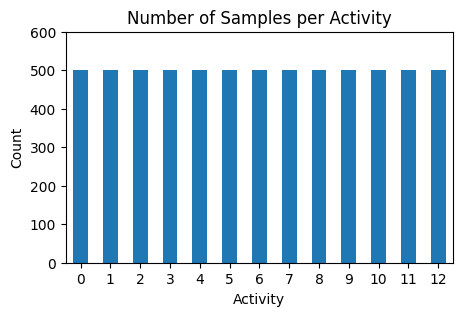

In [30]:
plt.figure(figsize=(5,3))
plt.title('Number of Samples per Activity')
plt.ylim(0, 600)
plt.xlabel("Activity")
plt.ylabel("Count")
df['Activity'].value_counts().plot.bar(rot=0)
plt.show()

In [31]:
# Giving Labels to our Activity Values
activities_label_dict = {
    0: "None",
    1: "Standing still",
    2: "Sitting and relaxing",
    3: "Lying down",
    4: "Walking",
    5: "Climbing stairs",
    6: "Waist bends forward",
    7: "Frontal elevation of arms",
    8: "Knees bending",
    9: "Cycling",
    10: "Jogging",
    11: "Running",
    12: "Jump front & back"
}

df = df.replace({"Activity": activities_label_dict})

<AxesSubplot: >

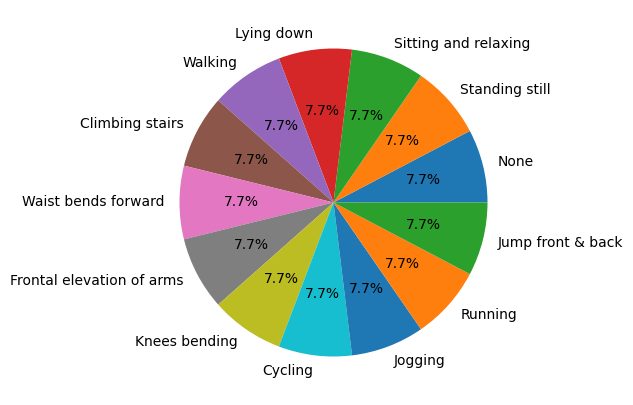

In [32]:
plt.figure(figsize=(8,5))
round(df["Activity"].value_counts()/df.shape[0]*100,2).plot.pie(autopct= '%2.1f%%',label='')

In [33]:
df.describe()

,acx,acy,acz,es1,es2,alx,aly,alz,glx,gly,...,arx,ary,arz,grx,gry,grz,mrx,mry,mrz,Subject
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,...,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,-7.540197,-0.180726,-1.062571,-0.000364,-0.006504,1.743718,-9.148809,-0.745986,0.085018,-0.565562,...,-3.584454,-5.745529,2.276196,-0.224988,-0.413740,0.358370,-0.415829,1.270927,0.799241,5.500000
std,5.923917,2.766635,4.556775,0.836767,0.853392,4.232571,5.177857,6.464758,0.465612,0.418246,...,6.212640,6.545231,4.339495,0.546232,0.545833,0.528342,33.713587,32.397165,84.579975,2.872502
min,-22.175000,-19.905000,-17.933000,-8.619600,-8.619600,-21.983000,-19.600000,-19.364000,-1.710600,-2.951200,...,-22.286000,-18.942000,-18.228000,-1.639200,-2.129400,-1.084100,-270.500000,-320.820000,-640.270000,1.000000
25%,-9.725650,-1.319575,-3.626300,-0.230250,-0.184200,0.122105,-10.144000,-3.433425,-0.365955,-0.812380,...,-5.340375,-9.512875,0.037769,-0.700000,-0.837780,-0.079741,-6.809200,-8.098550,-13.603000,3.000000
50%,-8.866250,-0.303210,-0.884515,-0.075353,-0.046049,1.324550,-9.598750,0.275380,0.176250,-0.692310,...,-2.552400,-7.597150,1.770250,-0.323530,-0.591380,0.428880,0.360770,0.348650,-0.712910,5.500000
75%,-5.132075,0.948810,1.008775,0.175820,0.146520,2.853900,-7.571275,1.811725,0.482370,-0.497190,...,-0.518065,-2.052700,5.217900,0.215690,-0.038501,0.834050,5.992625,8.650500,12.438000,8.000000
max,19.049000,16.818000,25.397000,6.593400,8.498200,20.001000,21.010000,24.715000,1.419300,1.752300,...,19.641000,21.933000,25.483000,1.415700,1.209400,1.775900,190.880000,328.870000,558.930000,10.000000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 129854 to 95543
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   acx       6500 non-null   float64
 1   acy       6500 non-null   float64
 2   acz       6500 non-null   float64
 3   es1       6500 non-null   float64
 4   es2       6500 non-null   float64
 5   alx       6500 non-null   float64
 6   aly       6500 non-null   float64
 7   alz       6500 non-null   float64
 8   glx       6500 non-null   float64
 9   gly       6500 non-null   float64
 10  glz       6500 non-null   float64
 11  mlx       6500 non-null   float64
 12  mly       6500 non-null   float64
 13  mlz       6500 non-null   float64
 14  arx       6500 non-null   float64
 15  ary       6500 non-null   float64
 16  arz       6500 non-null   float64
 17  grx       6500 non-null   float64
 18  gry       6500 non-null   float64
 19  grz       6500 non-null   float64
 20  mrx       6500 non-null 

In [35]:
# Encoding 
df = df.drop(['Subject'], axis=1)
le = LabelEncoder()
df['Activity'] = le.fit_transform(df['Activity'])

<AxesSubplot: >

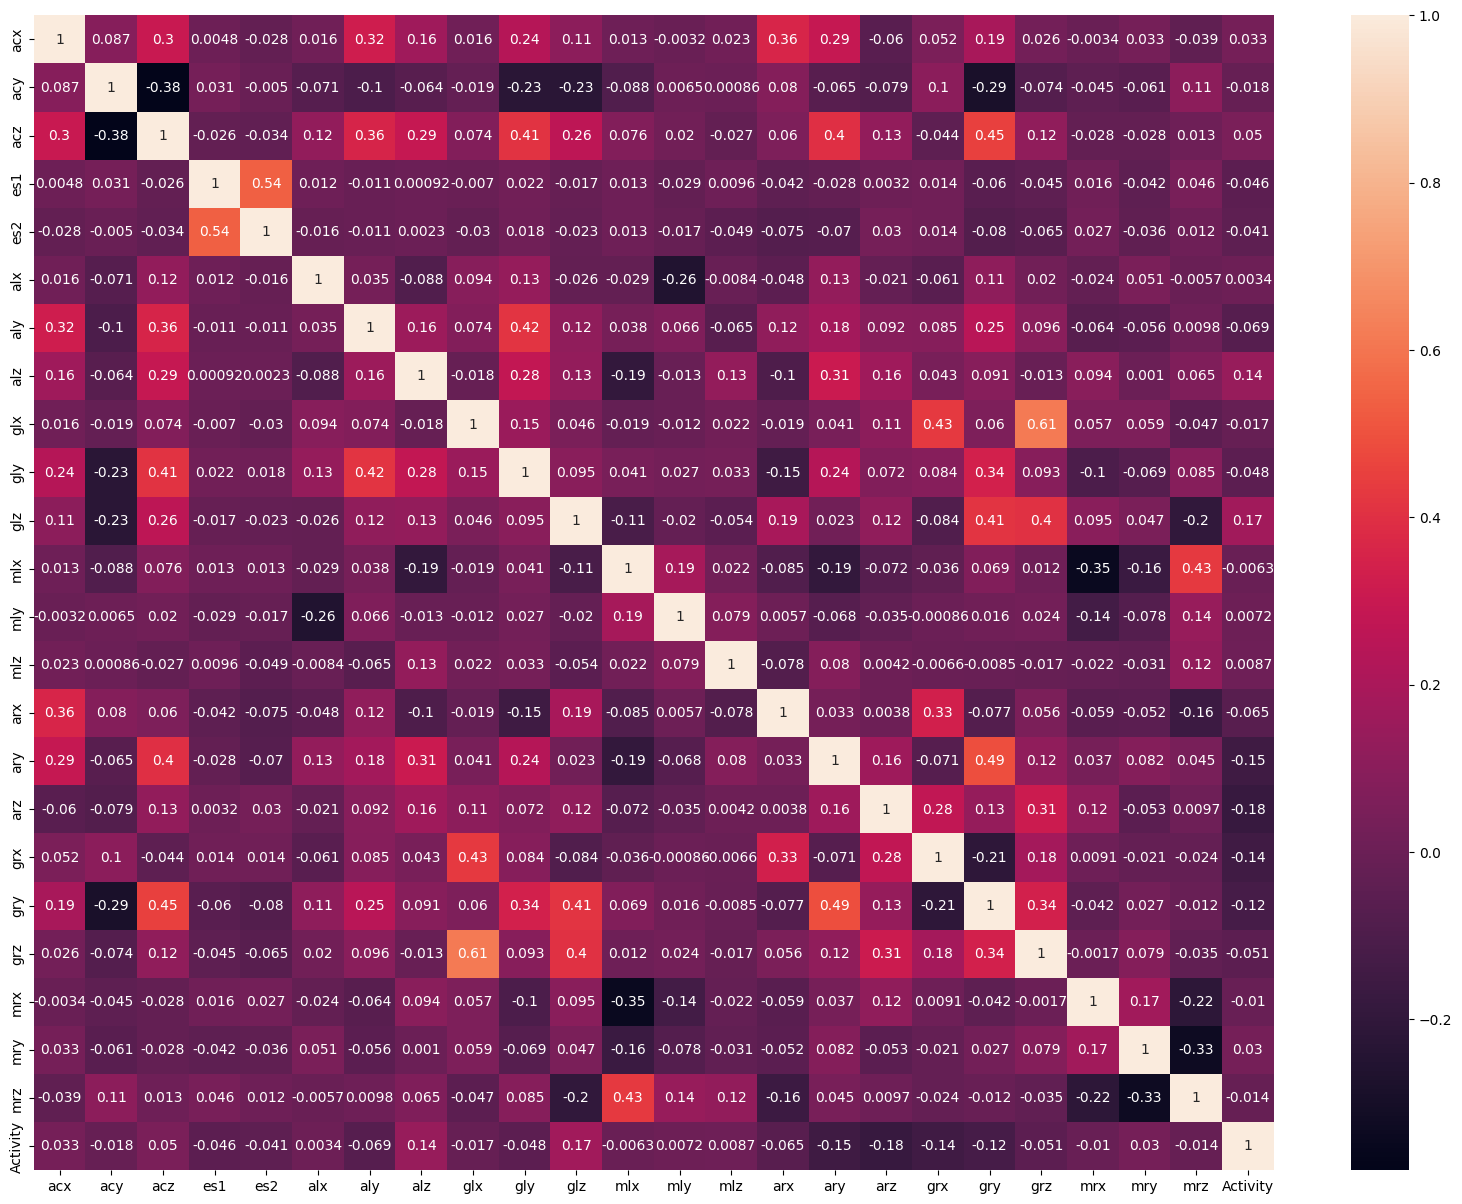

In [36]:
plt.subplots(figsize = (20, 15))
sns.heatmap(df.corr(), annot = True)

#### Train / Test Splitting

In [37]:
x = df.drop(['Activity'], axis=1) 
y = df['Activity'] 

In [38]:
# Scaling
ro_scaler = RobustScaler().fit(x)
x_scaled = pd.DataFrame(ro_scaler.transform(x), columns = ['acx', 'acy', 'acz', 'es1', 'es2', 'alx', 'aly', 'alz', 'glx', 'gly',
       'glz', 'mlx', 'mly', 'mlz', 'arx', 'ary', 'arz', 'grx', 'gry', 'grz',
       'mrx', 'mry', 'mrz'])


In [39]:
# Creating train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, stratify=y) 

In [40]:
print('X Train Shape:', x_train.shape)
print('y Train Shape:', y_train.shape, '\n')
print('X Test Shape:', x_test.shape)
print('y Test Shape:', y_test.shape)

X Train Shape: (4550, 23)
y Train Shape: (4550,) 

X Test Shape: (1950, 23)
y Test Shape: (1950,)


In [41]:
# Creating a dictionary that contains the name of the method and the scores and the features of these method
benchmark = {} 
models = [LogisticRegression(), KNeighborsClassifier(n_neighbors=5)]

### Without Features Selections

In [42]:
for model in models:
    best_score = evaluation.evaluate_model(x_train, y_train, model, stratify = y_train ,  test_size=0.33, number_of_states = 20, acc =  evaluation.eval_metrics)[1]
    best_features = x_train.columns
    benchmark[type(model).__name__ ] = dict({'w/o FS': dict({'test_score':best_score,  'features':best_features})})

## Feature Selection

### Feature Selection Using Laplace Score

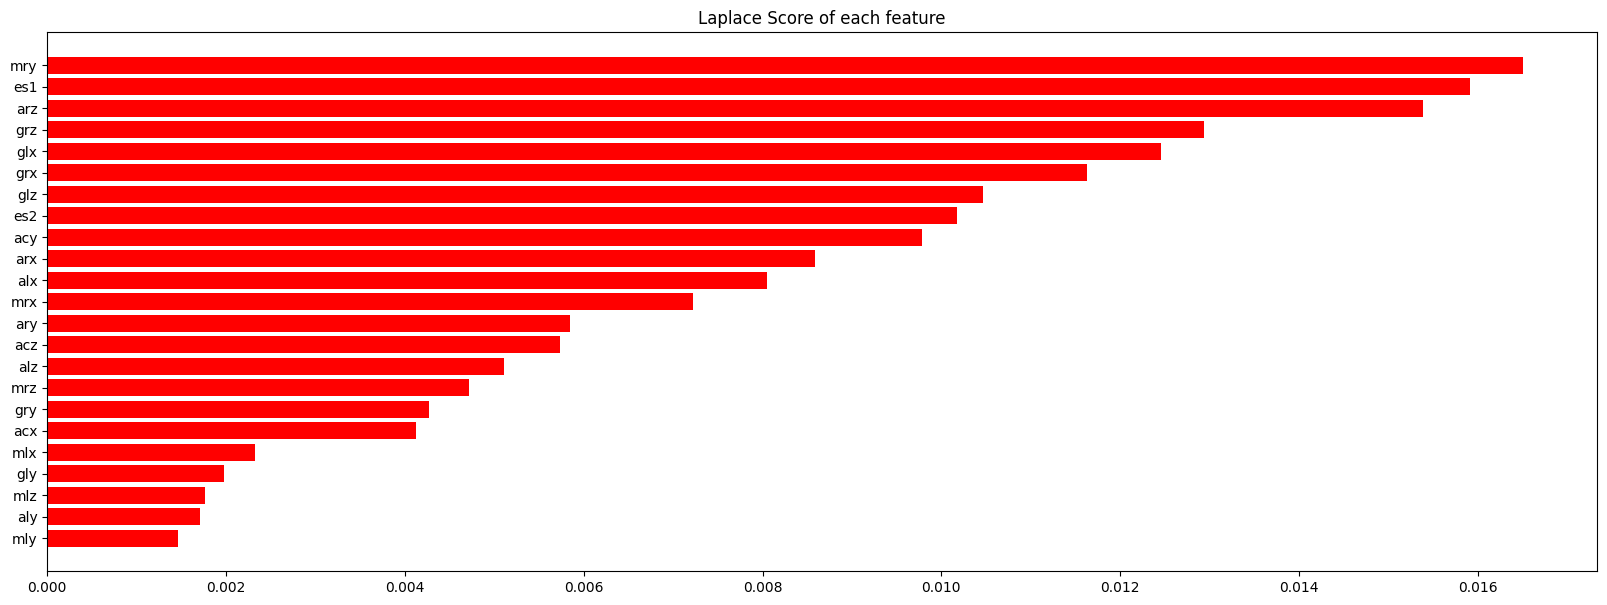

KNeighborsClassifier


100%|██████████| 21/21 [01:42<00:00,  4.88s/it]


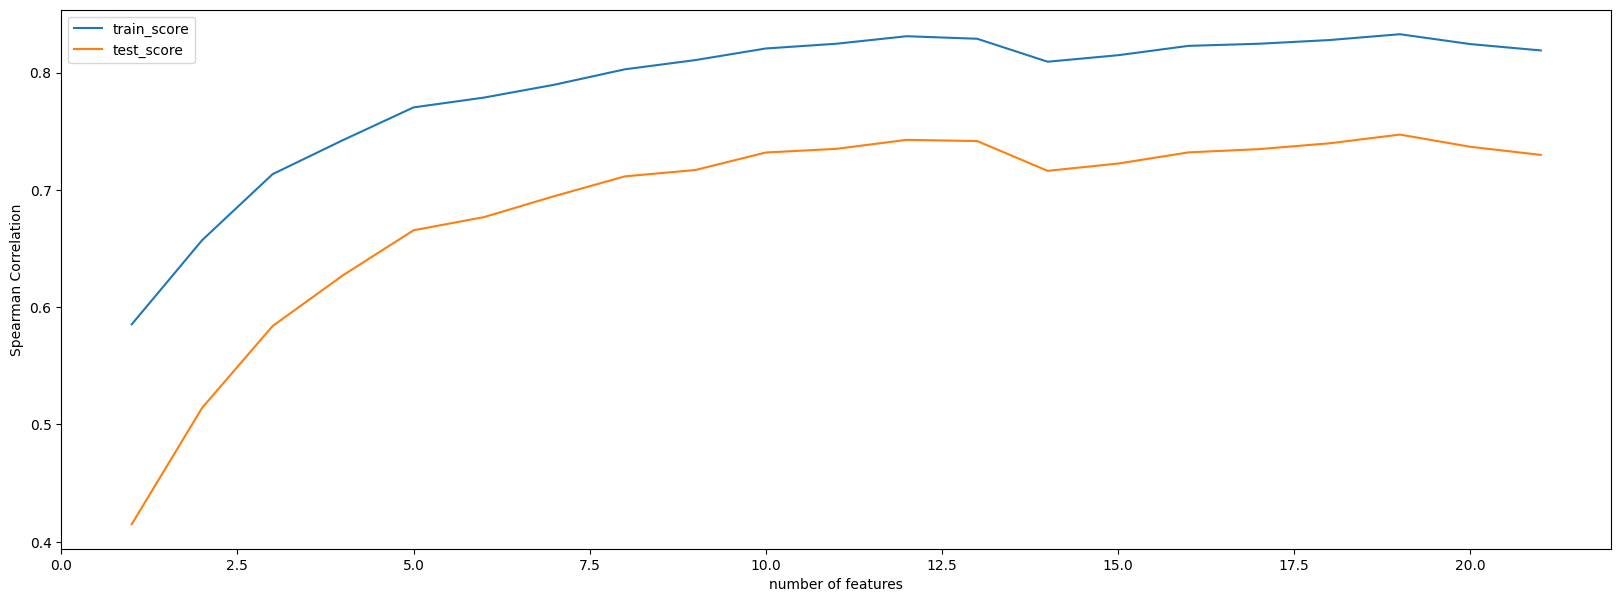

The best_score of KNeighborsClassifier =  [0.74717044 0.73593708 0.74717449 0.72496693]
The best_features of KNeighborsClassifier =  ['mly', 'aly', 'mlz', 'gly', 'mlx', 'acx', 'gry', 'mrz', 'alz', 'acz', 'ary', 'mrx', 'alx', 'arx', 'acy', 'es2', 'glz', 'grx', 'glx', 'grz', 'arz']


In [43]:
best_score, best_features = features_selection.laplace_features_selection(x_train, y_train, x_test, models, y_train,  number_of_states = 20, metric = evaluation.eval_metrics)

for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__]['Laplace'] = {'test_score':best_score[i], 'features':best_features[i]}
    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])


##### Feature Selection Using Fisher Score

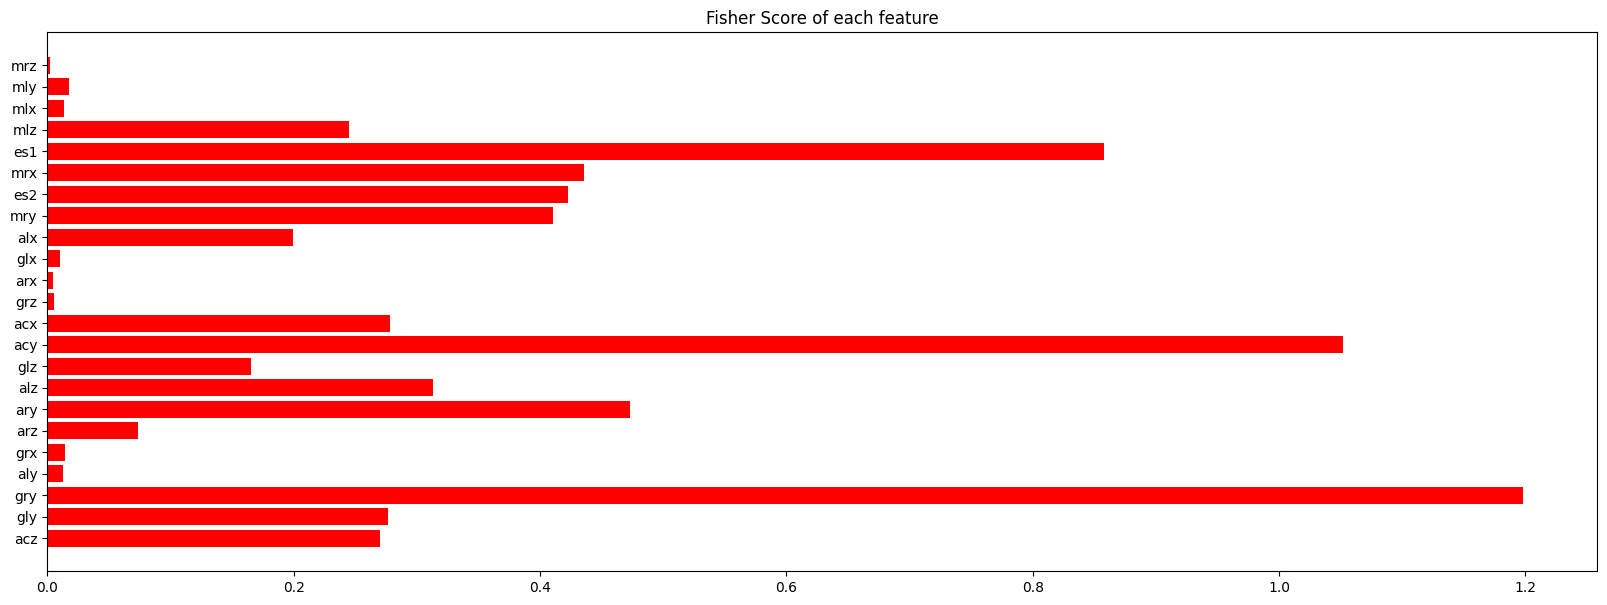

KNeighborsClassifier


100%|██████████| 21/21 [01:40<00:00,  4.79s/it]


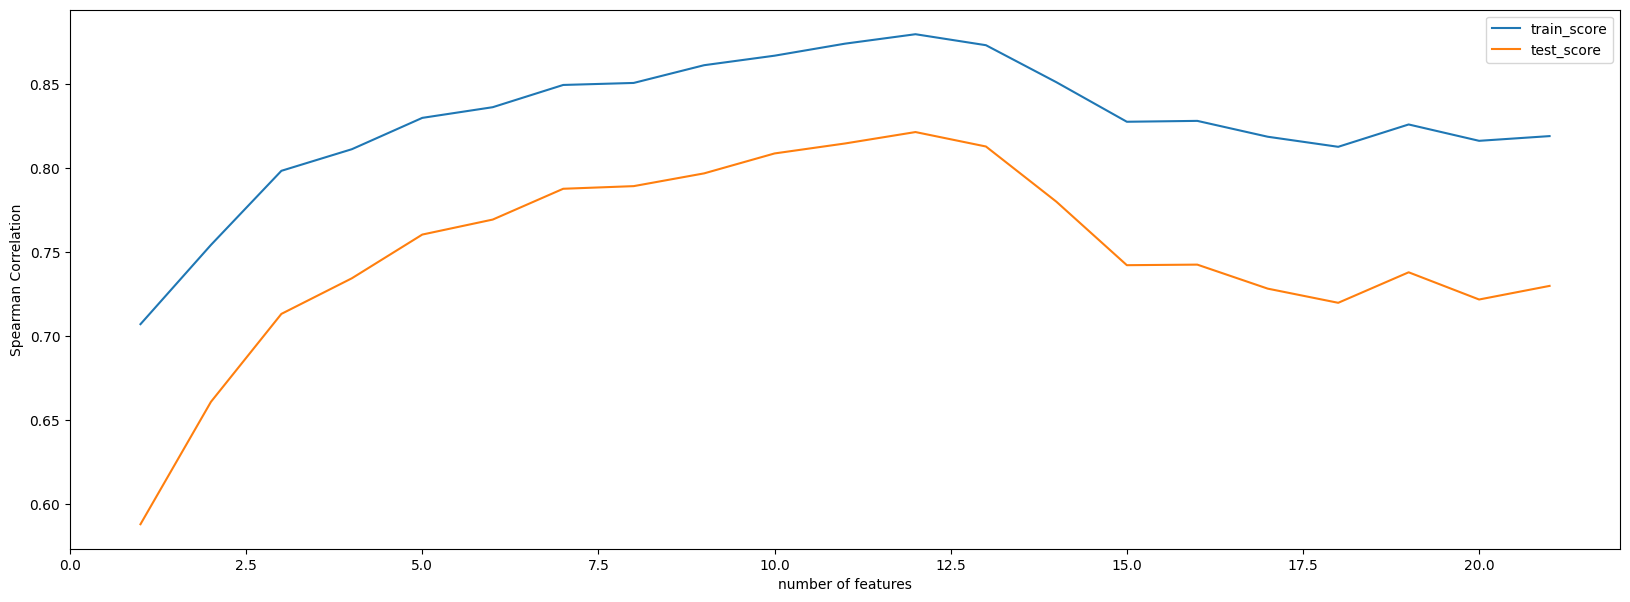

The best_score of KNeighborsClassifier =  [0.82130493 0.81396007 0.82131242 0.80401009]
The best_features of KNeighborsClassifier =  ['acz', 'gly', 'gry', 'aly', 'grx', 'arz', 'ary', 'alz', 'glz', 'acy', 'acx', 'grz', 'arx', 'glx']


In [44]:
best_score, best_features = features_selection.fisher_feature_selection(x_train, y_train, x_test, models, y_train,  number_of_states = 20, metric = evaluation.eval_metrics)

for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__]['Fisher'] = {'test_score':best_score[i], 'features':best_features[i]}
    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])

##### Feature Selection Using MRMR

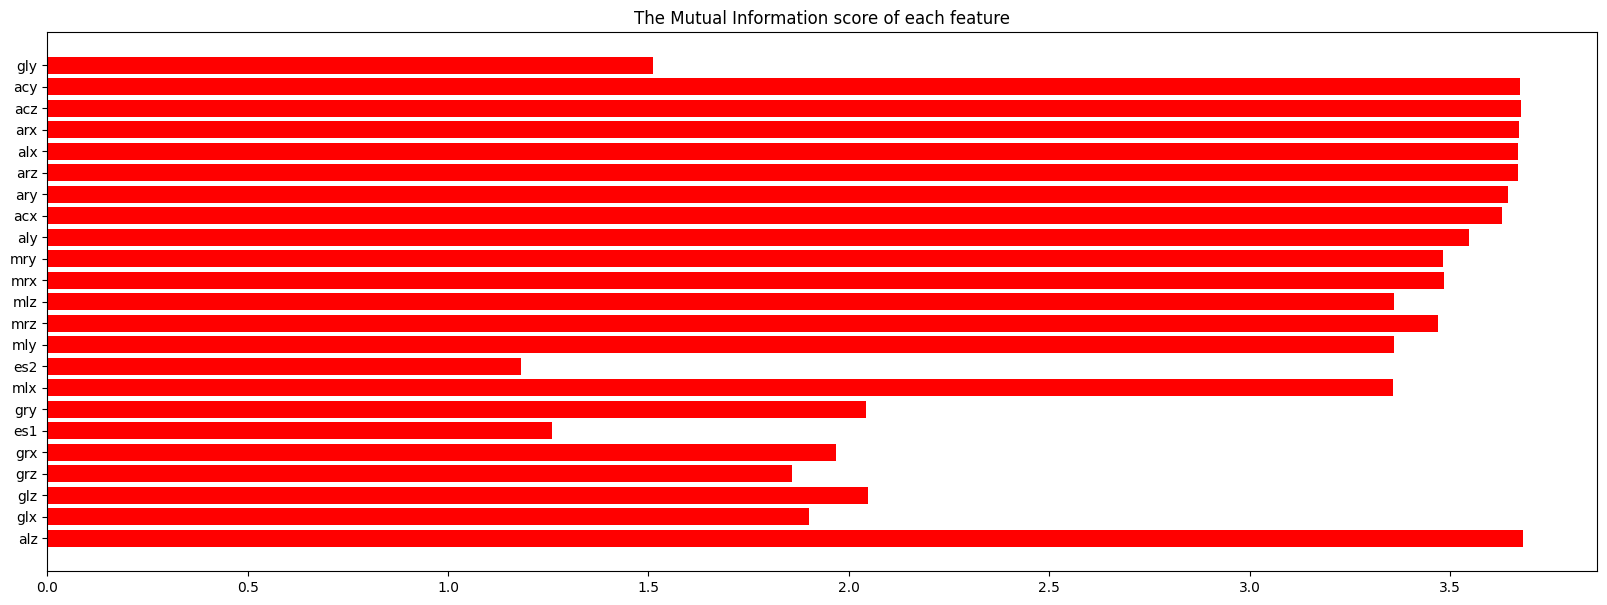

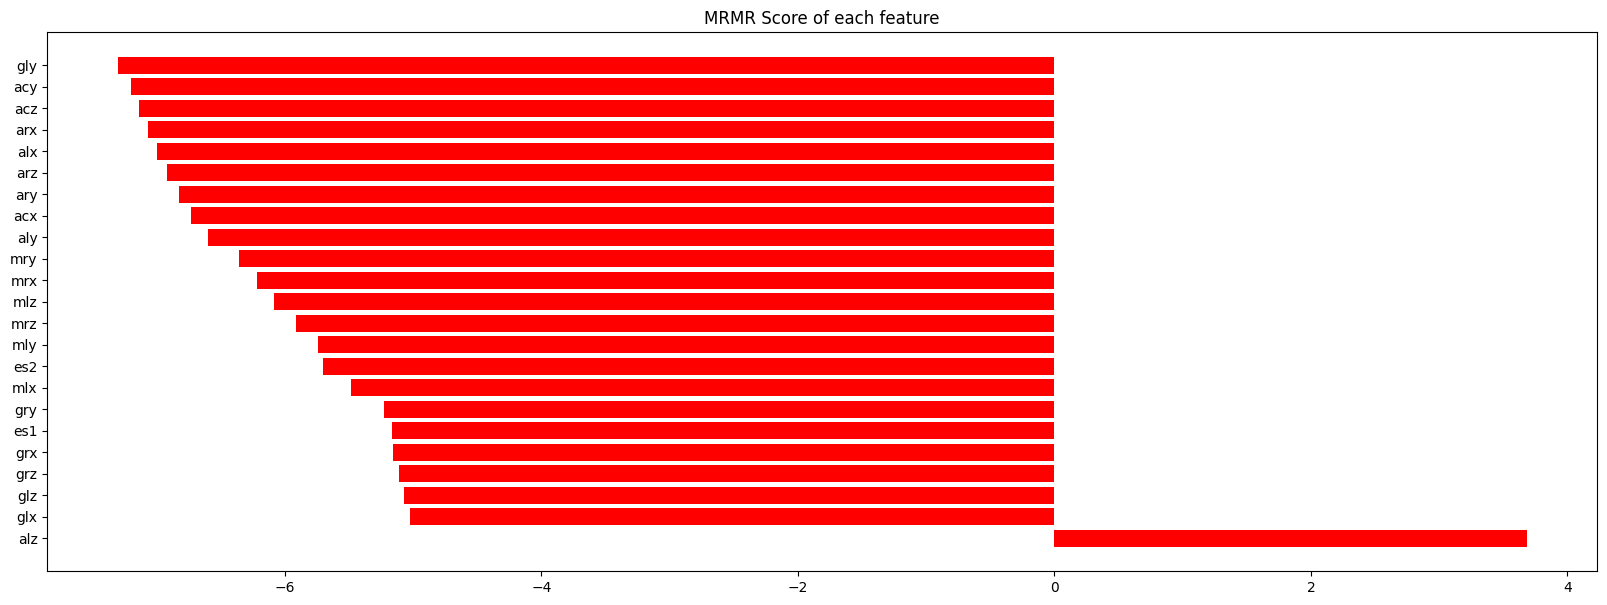

KNeighborsClassifier


100%|██████████| 21/21 [01:41<00:00,  4.84s/it]


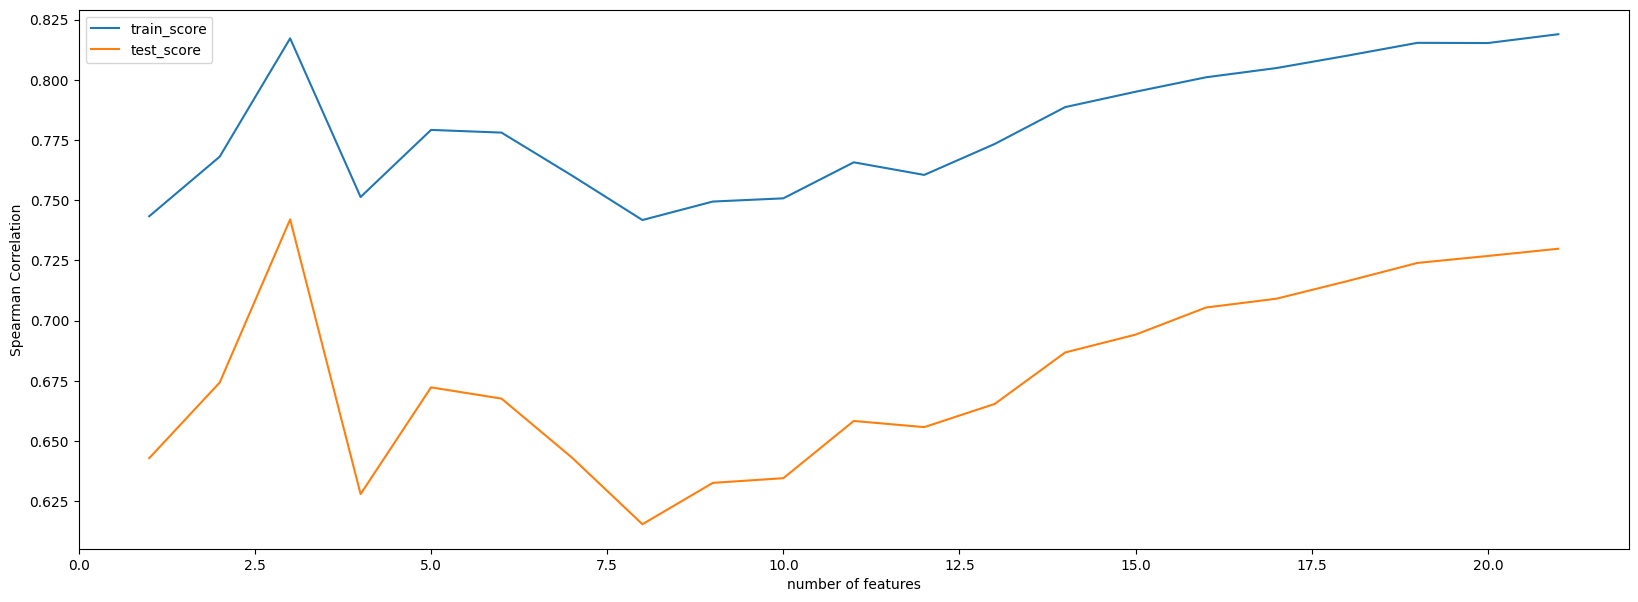

The best_score of KNeighborsClassifier =  [0.74201065 0.72663924 0.74201649 0.72056692]
The best_features of KNeighborsClassifier =  ['alz', 'glx', 'glz', 'grz', 'grx']


In [45]:
best_score, best_features = features_selection.MRMR_features_selection(x_train, y_train, x_test, models, y_train,  number_of_states = 20, metric = evaluation.eval_metrics)

for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__]['MRMR'] = {'test_score':best_score[i], 'features':best_features[i]}
    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])

##### Feature Selection Using CIFE

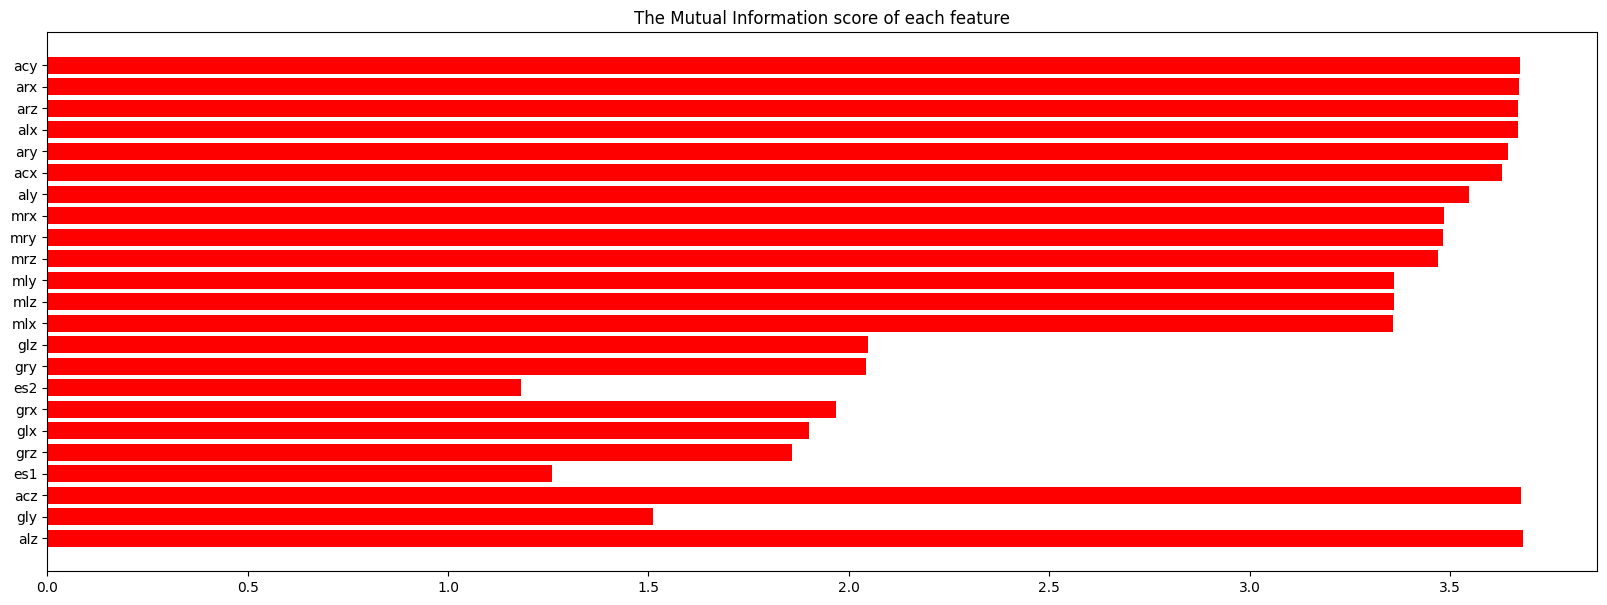

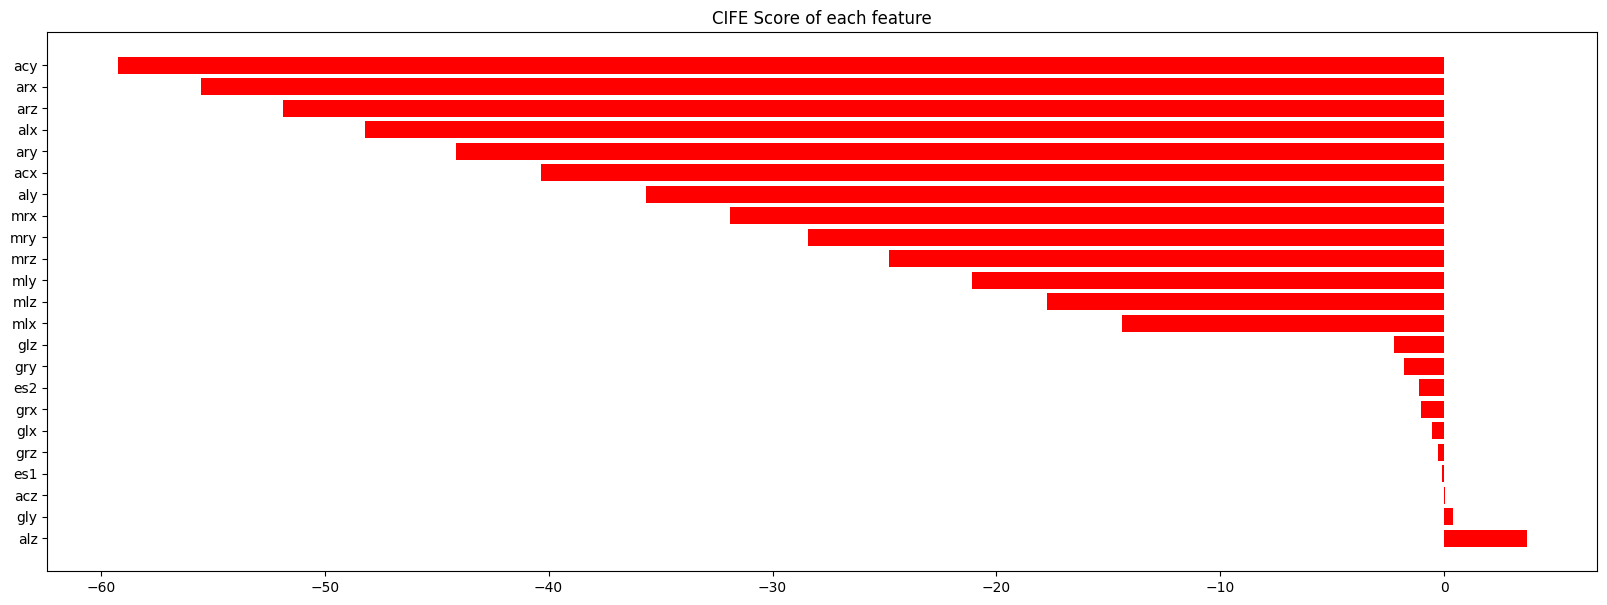

KNeighborsClassifier


100%|██████████| 21/21 [01:43<00:00,  4.94s/it]


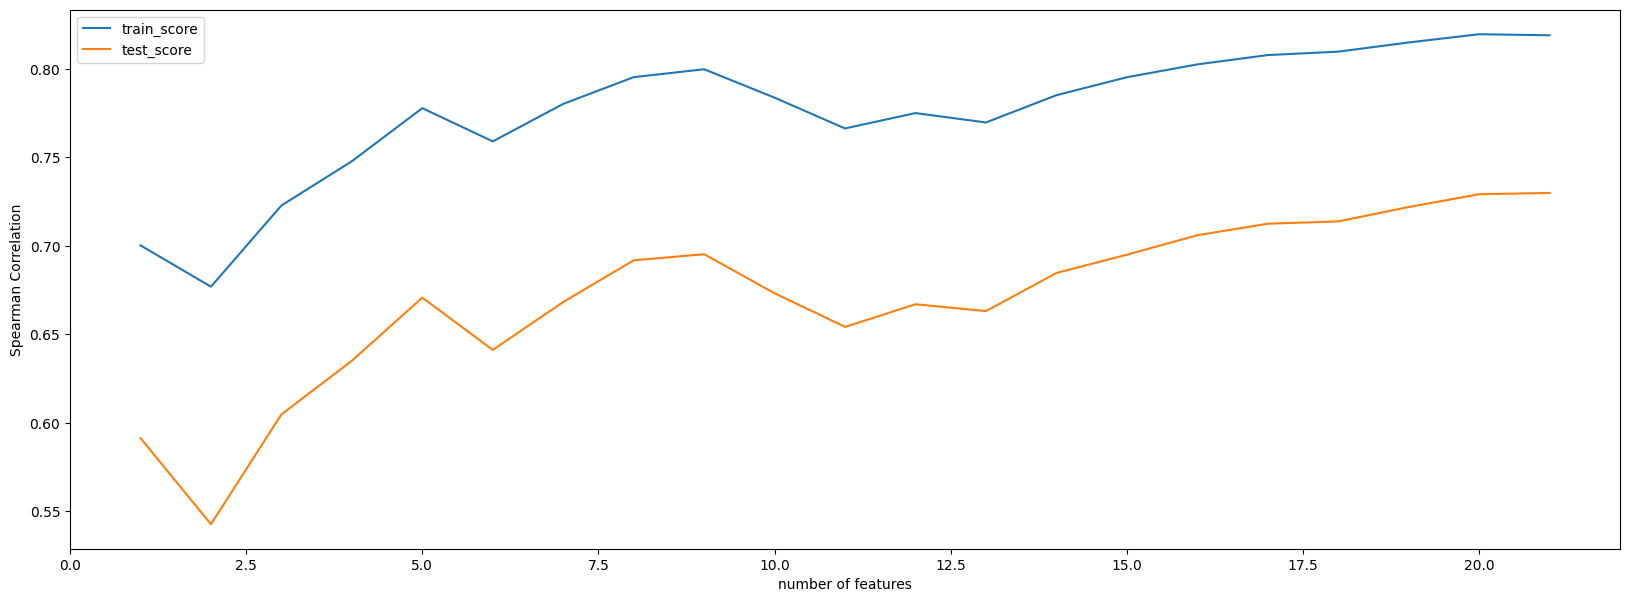

The best_score of KNeighborsClassifier =  [0.7298269  0.72106839 0.72983422 0.7077669 ]
The best_features of KNeighborsClassifier =  ['alz', 'gly', 'acz', 'es1', 'grz', 'glx', 'grx', 'es2', 'gry', 'glz', 'mlx', 'mlz', 'mly', 'mrz', 'mry', 'mrx', 'aly', 'acx', 'ary', 'alx', 'arz', 'arx', 'acy']


In [46]:
best_score, best_features = features_selection.CIFE_features_selection(x_train, y_train, x_test, models, y_train,  number_of_states = 20, metric = evaluation.eval_metrics)

for i in range(len(models)):
    model = models[i]
    benchmark[type(model).__name__]['CIFE'] = {'test_score':best_score[i], 'features':best_features[i]}
    print("The best_score of " + type(model).__name__ + " = ", best_score[i])
    print("The best_features of " + type(model).__name__  +" = ", best_features[i])



### Results

In [47]:
results = pd.DataFrame(columns=['model', 'w/o FS', 'Laplace', 'MRMR', 'Fisher', 'CIFE'])
cols = ['w/o FS', 'Laplace', 'MRMR', 'Fisher', 'CIFE']
for i in benchmark.keys():
    res = [i]
    for z in cols:
 
        if(z in benchmark[i]):
            res.append(benchmark[i][z]['test_score'][0])
        else:
            res.append(np.nan)
    results.loc[len(results)] = res

In [48]:
print(tabulate(results, headers='keys', tablefmt='fancy_grid'))

╒════╤══════════════════════╤══════════╤═══════════╤══════════╤══════════╤══════════╕
│    │ model                │   w/o FS │   Laplace │     MRMR │   Fisher │     CIFE │
╞════╪══════════════════════╪══════════╪═══════════╪══════════╪══════════╪══════════╡
│  0 │ KNeighborsClassifier │ 0.729827 │   0.74717 │ 0.742011 │ 0.821305 │ 0.729827 │
╘════╧══════════════════════╧══════════╧═══════════╧══════════╧══════════╧══════════╛


In [49]:
freq = dict()
for i in benchmark.keys():
    for j in benchmark[i].keys():
    
        if(i not in freq):
            freq[i] = dict()
        if(j not in freq[i]):
            freq[i][j] = 0
        freq[i][j] += (len(benchmark[i][j]['features'])/x_train.shape[1])*100


In [50]:
freq_data = pd.DataFrame(freq).T
freq_data

,CIFE,Fisher,Laplace,MRMR,w/o FS
KNeighborsClassifier,100.0,60.869565,91.304348,21.73913,100.0
